In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools as it

# Exercise 2: Rigid and perspective transformations in homogeneous coordinates

In [141]:
def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
    return np.hstack(points)/2

def Pi(points):
    n,p = points.shape
    new_points = np.vstack((points, np.ones(p)))
    return new_points

def PiInv(points):
    n,p = points.shape
    new_points = points[:-1]/points[-1]
    return new_points

# Mathematical exercises: Pinhole camera

Modern camera with completely square pixels => 
$\alpha$ = 1,
$\beta$ = 0

## Exercise 2.1

Resolution of 800 × 800 pixels.

In [142]:
def projectpoints(K,R,t,Q):
    homogeneous = Pi(Q)
    P = K @ ( np.hstack((R,t)) )
    q = P @ homogeneous
    q = PiInv(q)
    return q

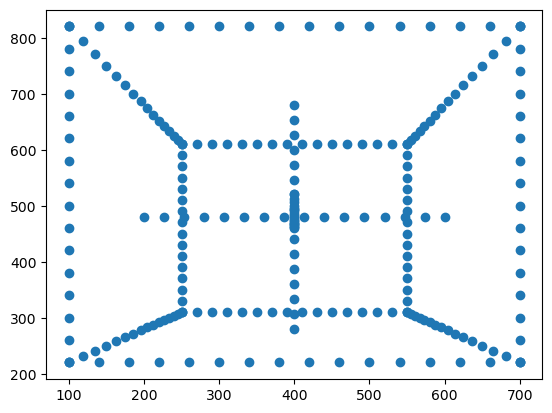

In [143]:
f = 600
alpha, beta = 1, 0
dx, dy = 400, 400

K = np.array([[f,beta*f,dx],[0,alpha*f,dy],[0,0,1]])
R = np.identity(3)
t = np.array([[0], [0.2], [1.5]])

Q = box3d(n=16)
q = projectpoints(K,R,t,Q)

plt.scatter(q[0,:], q[1,:])
plt.show()

Some points have an y value greater than 800, and are not visible in the image, as they are outside
the image sensor

In [144]:
P1 = np.array([-0.5,-0.5,-0.5])
P1.shape += (1,)
projectpoints(K,R,t,P1)

array([[100.],
       [220.]])

## Exercise 2.2

The distortion coefficients are k3 = −0.2, k5 = 0, k7 = 0

In [145]:
def dist(distCoeffs,q):
    r = np.sqrt(q[0,:]**2+q[1,:]**2)
    dr = distCoeffs[0]*r**2 + distCoeffs[1]*r**4 + distCoeffs[2]*r**6
    q = q*(1+dr)
    return q

def projectpoints(K,R,t,distCoeffs,Q):
    Q = Pi(Q)
    q = np.hstack((R,t)) @ Q
    q = PiInv(q)
    
    q = dist(distCoeffs,q)
    
    q = Pi(q)
    p = K @ q 
    p = PiInv(p)
    return p

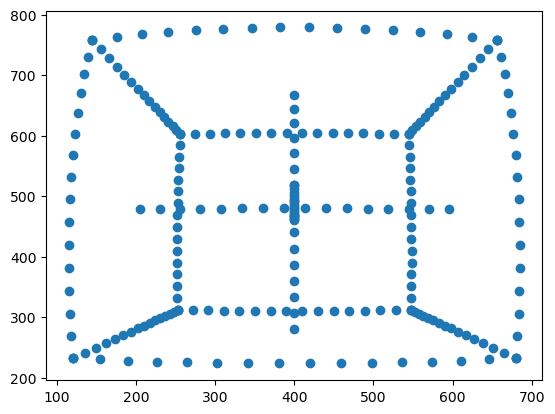

In [146]:
distCoeffs = np.array([-0.2, 0, 0])
distCoeffs.shape += (1,)

q = projectpoints(K,R,t,distCoeffs,Q)

plt.scatter(q[0,:], q[1,:])
plt.show()

All the points are now projecting inside the image, and will thus be visible.

In [147]:
projectpoints(K,R,t,distCoeffs,P1)

array([[120.4 ],
       [232.24]])

## Exercise 2.3

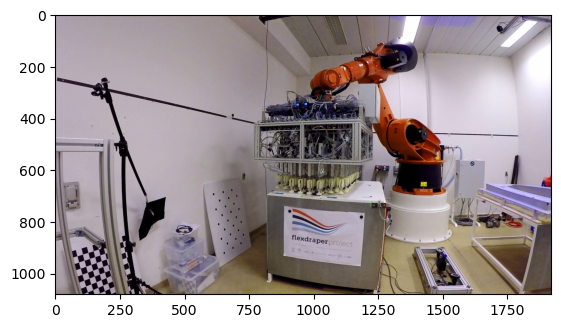

In [148]:
im = cv2.imread('gopro_robot.jpg')[:,:,::-1]
im = im.astype(float)/255
plt.imshow(im)

In [149]:
h, l = im.shape[:2]
dy, dx = h/2, l/2
f = 0.455732*l
alpha, beta = 1, 0

K = np.array([[f,beta*f,dx],[0,alpha*f,dy],[0,0,1]])
R = np.identity(3)
t = np.array([[0], [0.2], [1.5]])
distCoeffs = np.array([-0.245031, 0.071524, -0.00994978])
distCoeffs.shape += (1,)

In [150]:
K

array([[875.00544,   0.     , 960.     ],
       [  0.     , 875.00544, 540.     ],
       [  0.     ,   0.     ,   1.     ]])

## Exercise 2.4

In [170]:
def undistortImage(im, K, distCoeffs):
    x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
    p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1) # homogeneous coord
    
    q = np.linalg.inv(K) @ p
    q_d = Pi(dist(distCoeffs, PiInv(q)))
    p_d = K @ q_d
    
    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)
    assert (p_d[2]==1).all(), 'You did a mistake somewhere'
    im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)
    return im_undistorted

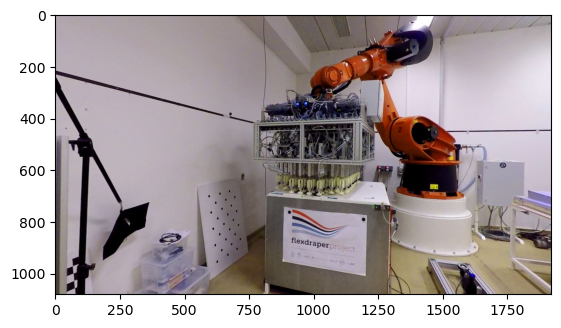

In [172]:
im_undistorted = undistortImage(im, K, distCoeffs)
plt.imshow(im_undistorted)

# Homographies

## Exercise 2.5

In [311]:
p = np.array([[1, 0, 2, 2], [1, 3, 3, 4]])

H = np.array([[-2, 0, 1],
              [1, -2, 0],
              [0, 0, 3]])

q = PiInv(H @ Pi(p))
q

array([[-0.33333333,  0.33333333, -1.        , -1.        ],
       [-0.33333333, -2.        , -1.33333333, -2.        ]])

## Exercise 2.6

In [312]:
def hest(q1,q2):
    n,p = q1.shape
    q1 = Pi(q1)
    q2 = Pi(q2)
    
    B = np.zeros((3*p,9))
    for i in range(p):
        M = np.array([[0,-1,q1[1,i]],
                      [1,0,-q1[0,i]],
                      [-q1[1,i],q1[0,i],0]])
        Bi = np.kron(q2[:,i], M)
        B[i*3:(i+1)*3,:] = Bi
        
    H = np.linalg.svd(B)[2][-1,:].reshape(3,3).T
    return -H/H[0,0]*2

In [313]:
q1 = q
q2 = p
hest(q1,q2)

array([[-2.00000000e+00,  2.72677092e-16,  1.00000000e+00],
       [ 1.00000000e+00, -2.00000000e+00, -2.00313631e-15],
       [-2.63128394e-17,  1.64623101e-17,  3.00000000e+00]])

## Exercise 2.7

In [314]:
def normalize2d(p):
    mu = np.mean(p,axis=1)
    sigma = np.std(p,axis=1)
    Tinv = np.array([[sigma[0],0,mu[0]],
                     [0,sigma[1],mu[1]],
                     [0,0,1]])
    T = np.linalg.inv(Tinv)
    return T

In [315]:
T = normalize2d(p)
q = PiInv(T @ Pi(p))
print(np.mean(q,axis=1),np.std(q,axis=1))

[ 1.11022302e-16 -5.55111512e-17] [1. 1.]


## Exercise 2.8

In [316]:
def hest(q1,q2,normalize = False):
    n,p = q1.shape
    
    if normalize == True:
        T1 = normalize2d(q1)
        T2 = normalize2d(q2)
        q1 = T1 @ Pi(q1)
        q2 = T2 @ Pi(q2)
    else:
        q1 = Pi(q1)
        q2 = Pi(q2)
    
    B = np.zeros((3*p,9))
    for i in range(p):
        M = np.array([[0,-1,q1[1,i]],
                      [1,0,-q1[0,i]],
                      [-q1[1,i],q1[0,i],0]])
        Bi = np.kron(q2[:,i], M)
        B[i*3:(i+1)*3,:] = Bi
        
    H = np.linalg.svd(B)[2][-1,:].reshape(3,3).T
    
    if normalize == True:
        H = np.linalg.inv(T1) @ H @ T2
        
    return H

In [317]:
H = hest(q1,q2,True)
-H/H[0,0]*2

array([[-2.00000000e+00, -1.00556972e-15,  1.00000000e+00],
       [ 1.00000000e+00, -2.00000000e+00,  5.44418318e-15],
       [ 1.19005116e-15,  3.10402929e-16,  3.00000000e+00]])

## Exercise 2.9

In [318]:
q2 = np.random.randn(2, 100)
q2h = np.vstack((q2, np.ones((1, 100))))
H_true = np.random.randn(3,3)
q1h = H_true@q2h
q1 = PiInv(q1h)
Hhat = hest(q1,q2,normalize=True)
H_true - Hhat/Hhat[0,0]*H_true[0,0]

array([[ 0.00000000e+00,  4.99600361e-16, -2.20656826e-15],
       [ 2.22044605e-16, -6.66133815e-16,  3.33066907e-16],
       [-6.66133815e-16,  1.66533454e-16,  5.20417043e-17]])